# Data Retrieval 

In the code cell below, we will first import all relevant packages we will need for our data analyses and visualisations. These include pandas (pd), numpy (np), matplotlib.pyplot (plt), and yfinance (yf). The latter will allow us to download stock price data from Yahoo Finance. 

The last line of code will set the style for all plots created with matplotlib to ggplot. 

In [9]:
#Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

#Set the style for plots
plt.style.use("ggplot")

Next, we will prepare our data frame, which will include the 2020-2024 data for 10 stocks, namely: 
- Amazon (AMZN)
- Tesla (TSLA)
- JPMorgan (JPM)
- Walmart (WMT)
- Visa (V)
- Netflix (NFLX)
- Exxon Mobil (XOM)
- Procter & Gamble (PG)
- Johnson & Johnson (JNJ)
- Coca-Cola (KO)

We will pull the data from Yahoo Finance and save it to a single CSV file. 

In [10]:
#Download data from Yahoo Finance
tickers = ["AMZN", "TSLA", "JPM", "WMT", "V", "NFLX", "XOM", "PG", "JNJ", "KO"]
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")

#Create a separate "Ticker" column 
df = data.stack(level=1).reset_index()

#Rearrange so that all tickers of one company are shown before the tickers of the next company
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

#Save to a CSV file 
df.to_csv("portfolio_data.csv", index=False)

#Check date format
print("The date format is: \n", df.Date.head())

#Load the data
df = pd.read_csv("portfolio_data.csv")

#Convert to a datetime object
df["Date"] = pd.to_datetime(df["Date"])

/tmp/ipykernel_3052/2668217325.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  10 of 10 completed
/tmp/ipykernel_3052/2668217325.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.stack(level=1).reset_index()


The date format is: 
 0   2020-01-02
1   2020-01-03
2   2020-01-06
3   2020-01-07
4   2020-01-08
Name: Date, dtype: datetime64[ns]


# Data Cleaning
Having prepared our data frame, we will make sure it does not contain any missing values or duplicates, and the index for each ticker is in ascending order. 

In [11]:
#Check for missing values
print("Missing data:", df.isnull().sum().sum())

#Check for ascending order in the index by ticker 
order = df.groupby("Ticker")["Date"].apply(lambda x: x.is_monotonic_increasing)
print("In ascending order:\n", order)

#Check for duplicates
print("Number of duplicates:", df.duplicated().sum())

Missing data: 0
In ascending order:
 Ticker
AMZN    True
JNJ     True
JPM     True
KO      True
NFLX    True
PG      True
TSLA    True
V       True
WMT     True
XOM     True
Name: Date, dtype: bool
Number of duplicates: 0


# Data Exploration
Now, let's explore the data. We will identify the closing prices for each stock and plot them over the 2020-2024 period.

Head: Ticker           AMZN         JNJ         JPM         KO        NFLX  \
Date                                                                   
2020-01-02  94.900497  124.983658  120.733551  46.419701  329.809998   
2020-01-03  93.748497  123.536667  119.140312  46.166454  325.899994   
2020-01-06  95.143997  123.382561  119.045593  46.149578  335.829987   
2020-01-07  95.343002  124.135971  117.021721  45.795036  330.750000   
2020-01-08  94.598503  124.118881  117.934608  45.879448  339.260010   

Ticker              PG       TSLA           V        WMT        XOM  
Date                                                                 
2020-01-02  107.748238  28.684000  183.872055  36.593369  54.634792  
2020-01-03  107.023598  29.534000  182.409698  36.270317  54.195549  
2020-01-06  107.172028  30.102667  182.015274  36.196487  54.611671  
2020-01-07  106.508469  31.270666  181.534210  35.861134  54.164726  
2020-01-08  106.962463  32.809334  184.641739  35.738075  53.347908  

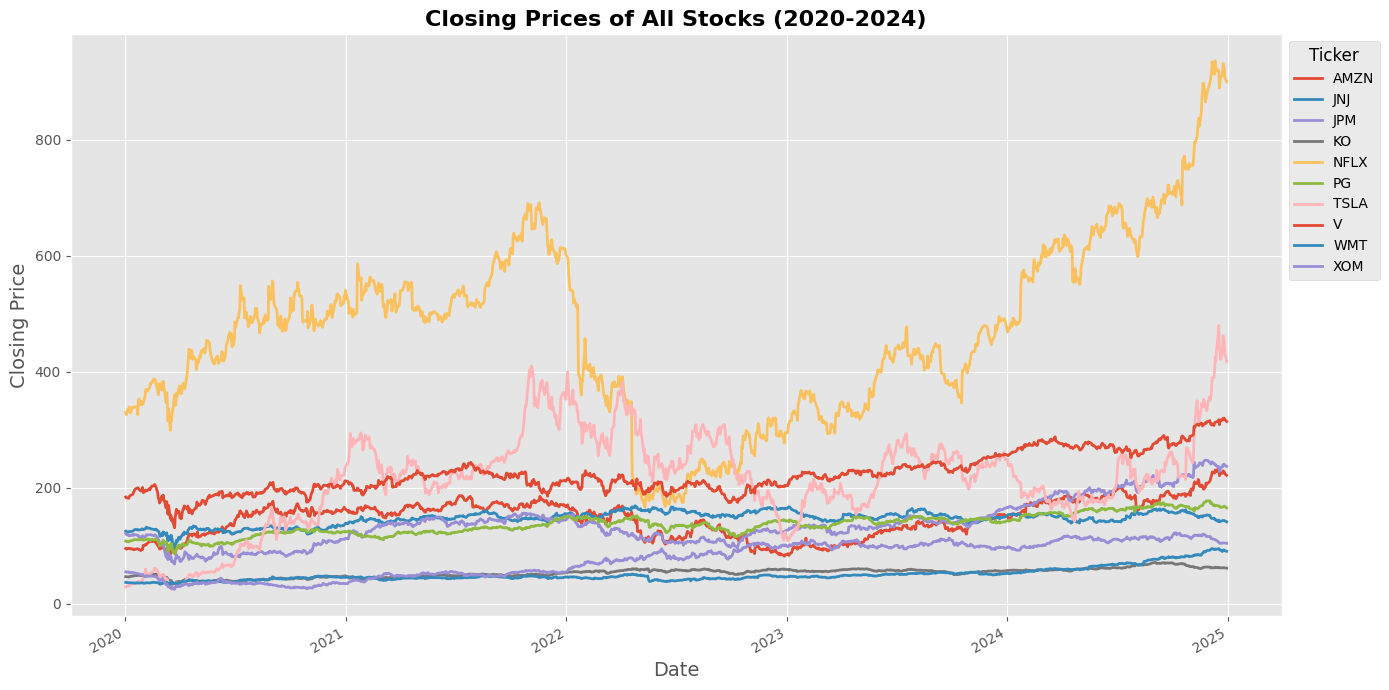

In [12]:
#Pivot table with closing prices 
pivot_df = df.pivot(index="Date", columns="Ticker", values="Close")

# Show the head
print("Head:", pivot_df.head())

# Show the tail
print("\nTail:", pivot_df.tail())

#Plot 
plot = pivot_df.plot(figsize=(14, 7), linewidth=2)
plot.set_title("Closing Prices of All Stocks (2020-2024)", fontsize=16, fontweight='bold')
plot.set_ylabel("Closing Price", fontsize=14)
plot.set_xlabel("Date", fontsize=14)
plot.legend(title="Ticker", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Backtesting - Bollinger Bands Mean Reversion Strategy

For each stock, we will now implement and backtest the Bollinger Bands Mean Reversion strategy to leverage the tendency of prices to revert to their mean. 

To do so, we will first subset each stock and set up our middle Bollinger Band (20-day SMA), as well as our upper and lower Bollinger Bands at two standard deviations from the middle band. Then, we will generate entry, hold, and exit signals according to the Bollinger Bands Mean Reversion strategy.

In [ ]:
#Subset Amazon 
AMZN = df.groupby("Ticker").get_group("AMZN").copy() 
AMZN.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
AMZN["SMA"] = AMZN.Close.rolling(window=20).mean()
AMZN["Dev"] = AMZN.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
AMZN["UpperBand"] = AMZN.SMA + (2 * AMZN.Dev)
AMZN["LowerBand"] = AMZN.SMA - (2 * AMZN.Dev)

#Generate entry and exit signals 
AMZN["Signal"] = np.nan
signal = 0  
for row in range(1, len(AMZN)):
	close = AMZN.Close.iloc[row]
	prev_close = AMZN.Close.iloc[row-1]
	sma = AMZN.SMA.iloc[row]
	prev_sma = AMZN.SMA.iloc[row-1]

	if signal == 0:
		if close < AMZN.LowerBand.iloc[row]:
			AMZN.Signal.iloc[row] = 1
			signal = 1
		elif close > AMZN.UpperBand.iloc[row]:
			AMZN.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1:
		if close > sma and prev_close <= prev_sma:
			AMZN.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1:
		if close < sma and prev_close >= prev_sma:
			AMZN.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
AMZN.Signal = AMZN.Signal.ffill()

#We don't trade (0), if there is no signal 
AMZN.Signal = AMZN.Signal.fillna(0)

#Calculate the simple daily returns 


AMZN


/tmp/ipykernel_3052/2682506612.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  AMZN.Signal.iloc[row] = -1
/tmp/ipykernel_3052/2682506612.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



,Ticker,Close,High,Low,Open,Volume,SMA,Dev,UpperBand,LowerBand,Signal
Date,,,,,,,,,,,
2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000,NaN,NaN,NaN,NaN,0.0
2020-01-03,AMZN,93.748497,94.309998,93.224998,93.224998,75288000,NaN,NaN,NaN,NaN,0.0
2020-01-06,AMZN,95.143997,95.184502,93.000000,93.000000,81236000,NaN,NaN,NaN,NaN,0.0
2020-01-07,AMZN,95.343002,95.694504,94.601997,95.224998,80898000,NaN,NaN,NaN,NaN,0.0
2020-01-08,AMZN,94.598503,95.550003,94.321999,94.902000,70160000,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,AMZN,225.059998,226.880005,223.899994,225.009995,28070000,220.425999,9.393671,239.213341,201.638658,-1.0
2024-12-24,AMZN,229.050003,229.139999,226.130005,226.940002,15007500,221.806000,8.437937,238.681873,204.930127,-1.0
2024-12-26,AMZN,227.050003,228.500000,226.669998,228.500000,16146700,222.765500,7.838409,238.442319,207.088681,-1.0


Next, we will generate a buy signal when the stock's closing price falls below the lower Bollinger Band, as we expect a price increase towards the middle band. 

Conversely, we will initiate a sell signal when the stock's closing price exceeds the upper Bollinger Band, as we anticipate a price decrease towards the middle band.

In [ ]:
To generate entry and exit signals as described, you can use the following logic:

- **Buy signal (1):** When the price crosses below the lower band.
- **Sell signal (-1):** When the price crosses above the upper band.
- **Exit buy (0):** When the price crosses above the middle band after a buy.
- **Exit sell (0):** When the price crosses below the middle band after a sell.

Here’s how you can implement this logic:

First, initialize a signal DataFrame with zeros. Then, iterate through each ticker and apply the rules:

```python
Signal_df = pd.DataFrame(0, index=pivot_df.index, columns=pivot_df.columns)

for ticker in pivot_df.columns:
    position = 0  # 0: no position, 1: long, -1: short
    for i in range(1, len(pivot_df)):
        price = pivot_df[ticker].iloc[i]
        prev_price = pivot_df[ticker].iloc[i-1]
        lb = LowerBand[ticker].iloc[i]
        ub = UpperBand[ticker].iloc[i]
        sma = SMA[ticker].iloc[i]
        prev_sma = SMA[ticker].iloc[i-1]

        if position == 0:
            if price < lb:
                Signal_df[ticker].iloc[i] = 1  # Buy signal
                position = 1
            elif price > ub:
                Signal_df[ticker].iloc[i] = -1  # Sell signal
                position = -1
        elif position == 1:
            if price > sma and prev_price <= prev_sma:
                Signal_df[ticker].iloc[i] = 0  # Exit buy
                position = 0
        elif position == -1:
            if price < sma and prev_price >= prev_sma:
                Signal_df[ticker].iloc[i] = 0  # Exit sell
                position = 0

bollinger_df = pd.concat(
    {"Close": pivot_df, "SMA": SMA, "UpperBand": UpperBand, "LowerBand": LowerBand, "Signal": Signal_df},
    axis=1
)
bollinger_df
```

This approach ensures you only exit a position when the price crosses back to the middle band.

SyntaxError: invalid character '’' (U+2019) (2717927688.py, line 8)